#Setup

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import statsmodels.api as sm

pd.options.display.max_columns = 40


f = open('/content/drive/MyDrive/ColabForHouzz/megamerge.txt', "r")

filedata = f.read()

filedata = filedata.replace("\n", "")
filedata = filedata.replace("][][", ", ")
filedata = filedata.replace("][", ", ")

filedata = filedata.replace(", , ", ", ")

k = json.loads(filedata)


df = pd.read_json(filedata)

print('un ', df['Product ID'].unique().shape)

df.drop_duplicates(inplace=True,keep='last')

print('df shape ', df.shape)

df = df.dropna(subset=['Size/Weight'])

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


un  (5185,)
df shape  (6512, 18)


In [53]:
df.head(2)

,Price,Title,Reviews,Product ID,Manufactured By,Sold By,Size/Weight,Color,Materials,Assembly Required,Category,Style,Model # (MPN),Collection,Commercial-grade,Size,Weight,Designer
41,"$1,686",Modern Aspen White Microfiber Leather Sofa,10 Reviews,14231908.0,Zuri Furniture,Zuri Furniture,"W 80"" / D 42"" / H 32"" / 125 lb.",White,NaN,NaN,Sofas,Contemporary,NaN,NaN,NaN,NaN,NaN,NaN
49,$467,Sorrento Retro Upholstered Wooden 3-Seater Sof...,136 Reviews,51172786.0,Baxton Studio,Houzz,"W 70.59"" / D 29.45"" / H 32.96"" / 61.6 lb.",NaN,Faux Leather/Rubber Wood/MDF/LVL/Foam,Yes,Sofas,Midcentury,6770,Mid-Century,NaN,NaN,NaN,NaN


#Feature Engineering and Filtering

In [111]:
tempDf = df.copy()

tempDf = tempDf.fillna(0)
#get price


#Feature Extraction

tempDf['Title'] = tempDf['Title'].str.lower()

tempDf['Materials'] = tempDf['Materials'].str.lower()

tempDf['Price'] = tempDf['Price'].str.replace(',', '')
tempDf['Price'] = tempDf['Price'].str.replace('$', '').astype(float)

#get width (?<=W )(\d{1,3})
tempDf['width'] = tempDf['Size/Weight'].str.extract(r'(?<=W )(\d{1,3})').astype(float)

#get depth (?<=D )(\d{1,3})
tempDf['depth'] = tempDf['Size/Weight'].str.extract(r'(?<=D )(\d{1,3})').astype(float)

#get height (?<=H )(\d{1,3})
tempDf['height'] = tempDf['Size/Weight'].str.extract(r'(?<=H )(\d{1,3})').astype(float)

#get weight (?<=\/ )(\d+)
tempDf['weight'] = tempDf['Size/Weight'].str.extract(r'(?<=\/ )(\d+)').astype(float)

#convert to numeric
#tempDf[['width','depth','height','weight','Price']] = tempDf[['width','depth','height','weight','Price']].apply(pd.to_numeric)


#calculate volume
tempDf['volume'] = tempDf['width'] * tempDf['depth'] * tempDf['height']

#Calculate density
tempDf['density'] = tempDf['weight'] / tempDf['volume']

#Get Reviews
tempDf['ReviewAmount'] = tempDf['Reviews'].str.extract(r'(\d+)',expand=False).astype(float)

tempDf['ReviewAmount'] = tempDf['ReviewAmount'].fillna(0)

tempDf = tempDf.dropna(subset=['volume','density','Price'])

tempDf['lengthofmaterials'] = tempDf['Materials'].str.len()
tempDf['lengthoftitle'] = tempDf['Title'].str.len()


#drop lower used cataorgiers?

a = tempDf.groupby('Category').count()
a = a[a['Price'] > a['Price'].mean()]

tempDf = tempDf[tempDf['Category'].isin(a.index)]

#drop lower used styles?

a = tempDf.groupby('Style').count()
a = a[a['Price'] > a['Price'].mean()]

tempDf = tempDf[tempDf['Style'].isin(a.index)]

#drop zero density, means widht, height, length or weight is zero

tempDf = tempDf[tempDf['width'] != 0]

tempDf = tempDf[tempDf['lengthoftitle'] > 5]

#everything

tempDf['everything'] = tempDf['Manufactured By'].astype(str)  + tempDf['Sold By'].astype(str)  + tempDf['Size/Weight'].astype(str)  + tempDf['Color'].astype(str) + tempDf['Materials'].astype(str) + tempDf['Category'].astype(str) + tempDf['Style'].astype(str) + tempDf['Collection'].astype(str) + tempDf['Designer'].astype(str)

def myfunc(n):
  c =0
  for word in n['Title'].split():
    word = word.lower()
    if word in n['everything'].lower():
      c=c+1
  return c
    

tempDf['numt'] = tempDf.apply(myfunc,axis=1)

tempDf['numtitlewords'] = tempDf['Title'].str.count(' ')

tempDf['uniquewordsPercent'] =(tempDf['numtitlewords'] + 1 - tempDf['numt'] ) / tempDf['numtitlewords']
tempDf['uniquewords'] =(tempDf['numtitlewords'] + 1 - tempDf['numt'] ) 
#mention of mateirals in title

def myfunc2(n):
  c =0
  for word in n['Title'].split():
    word = word.lower()
    if word in n['Materials'].lower():
      c=c+1
  return c
tempDf['Materials'] = tempDf['Materials'].astype(str)
tempDf['mention_material'] = tempDf.apply(myfunc2,axis=1)


#Cataogry Encoding

#f = f.join(pd.get_dummies(f.Style, prefix='Style_'))

tempDf = tempDf.join(pd.get_dummies(tempDf['Category'],prefix='Type_'))

tempDf = tempDf.join(pd.get_dummies(tempDf['Style'],prefix='Style'))

#drop not needed columns

tempDf = tempDf.drop(columns=['Size','Weight','Product ID'])

#encode Assmebly yes no as 1 ,0

tempDf['Assembly Required'] = tempDf['Assembly Required'].str.replace('Yes', '1')
tempDf['Assembly Required'] = tempDf['Assembly Required'].str.replace('No', '0')
tempDf = tempDf.fillna(0)
tempDf['Assembly Required'] = tempDf['Assembly Required'].astype(int)

#Encode commerical grade
tempDf['Commercial-grade'] = tempDf['Commercial-grade'].str.replace('Yes','1')
tempDf = tempDf.fillna(0)
tempDf['Commercial-grade'] = tempDf['Commercial-grade'].astype(int)

tempNum = tempDf[tempDf.describe().columns]

#price * reviews number as popularity matrix? confirmed sales
#tempDf['confirmedSales'] = tempDf['ReviewAmount'] * tempDf['Price']

# tempDf.replace([np.inf, -np.inf], np.nan, inplace=True)
# tempDf = tempDf.dropna() 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


##Testing Part Of Speech Word Tokenizer

In [117]:

from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

def wordFunc(n):
  return nltk.pos_tag(word_tokenize(n['Title']))

def countNoun(n):
  c = 0
  for z in n['pos']:
    if(z[1] == 'JJ'): ##is noun
      c = c + 1
  return c



k = pd.DataFrame()

#k['tokens'] = word_tokenize(a['Title'].str)
#k['pos'] = nltk.pos_tag(text)

tempDf['pos'] = tempDf.apply(wordFunc,axis=1)
tempDf['jjcount'] = tempDf.apply(countNoun,axis=1)
tempDf['jjpercent'] = tempDf['nncount'] / (tempDf['numtitlewords'] +1)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


#Data Exploration

##QQPLOT

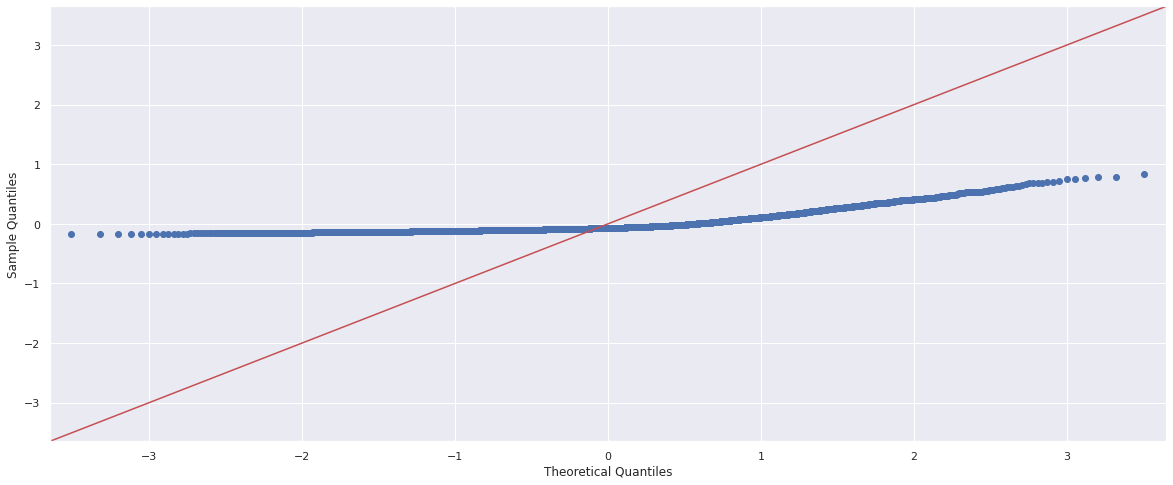

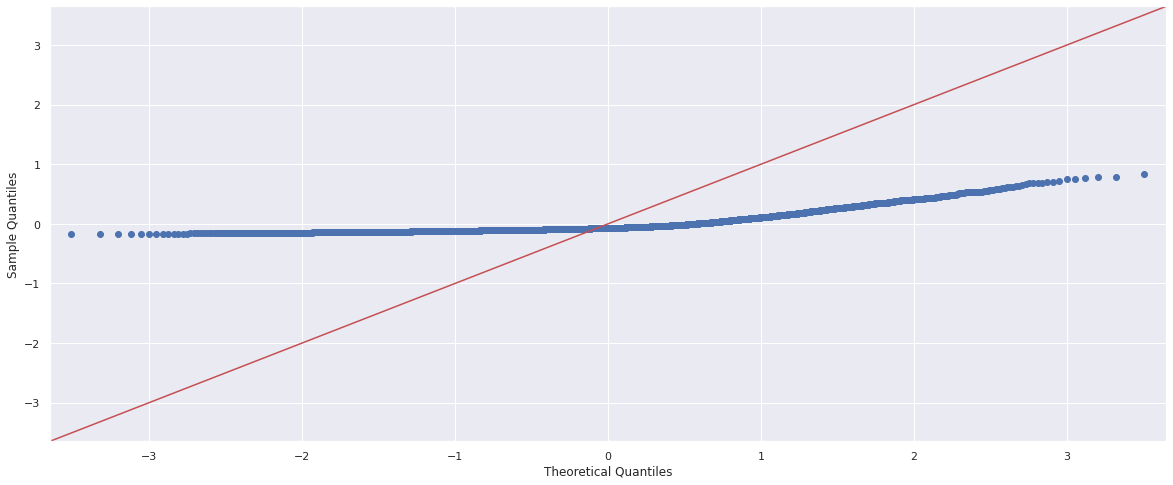

In [ ]:
#from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing

scaler = preprocessing.StandardScaler()
normi = preprocessing.Normalizer()

scaled = scaler.fit_transform(tempNum)
#print(type(scaled[:,0]))

scaled = normi.fit_transform(scaled)
sm.qqplot(scaled[:,0], line ='45')


number of categories:  37


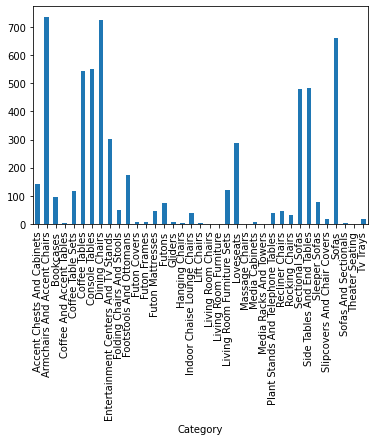

In [ ]:
print('number of categories: ', len(df['Category'].unique()))
df.groupby(by='Category').count()['Price'].plot(kind='bar')

Text(0.5, 1.0, 'pearson correlation')

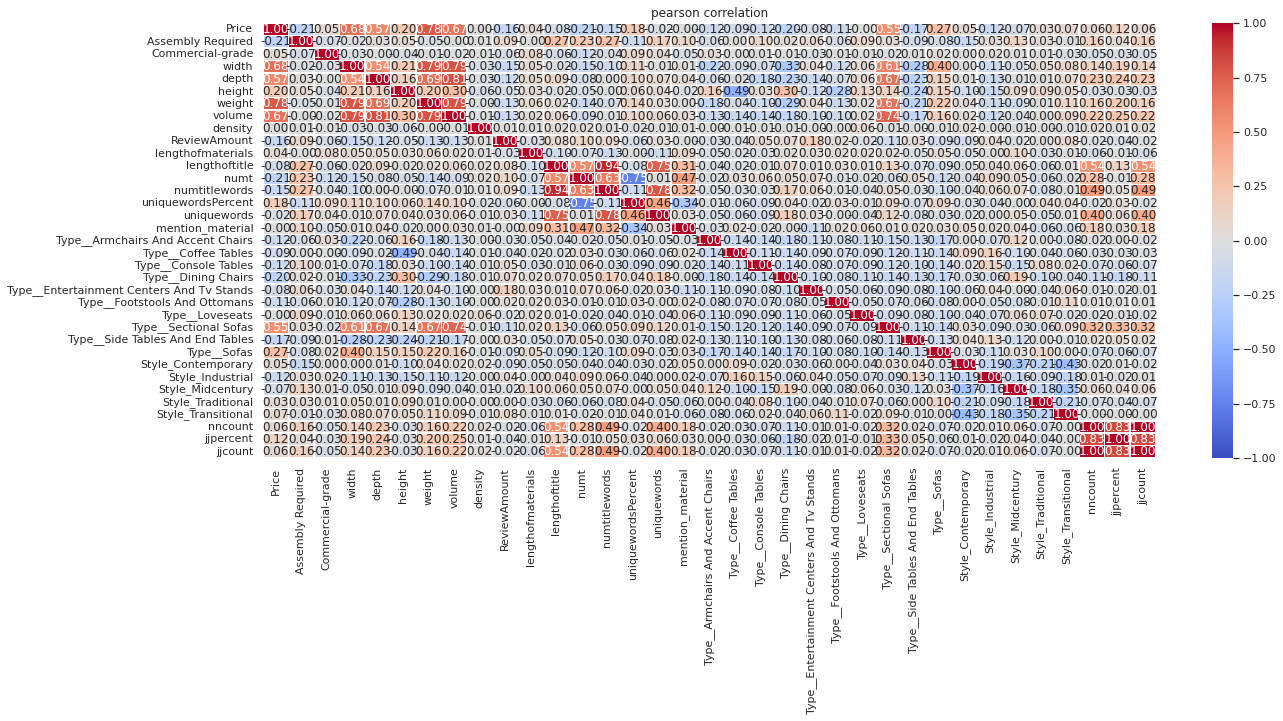

In [118]:
#Correlation Matrix
corr_matrix = tempDf[tempDf.describe().columns]
for col in corr_matrix.columns:
    if corr_matrix[col].dtype == "O":
         corr_matrix[col] = corr_matrix[col].factorize(sort=True)[0]
corr_matrix = corr_matrix.corr(method="pearson")
sns.set(rc = {'figure.figsize':(20,8)})
sns.heatmap(corr_matrix, vmin=-1., vmax=1., annot=True, fmt='.2f', cmap="coolwarm", cbar=True, linewidths=0.5)
plt.title("pearson correlation")

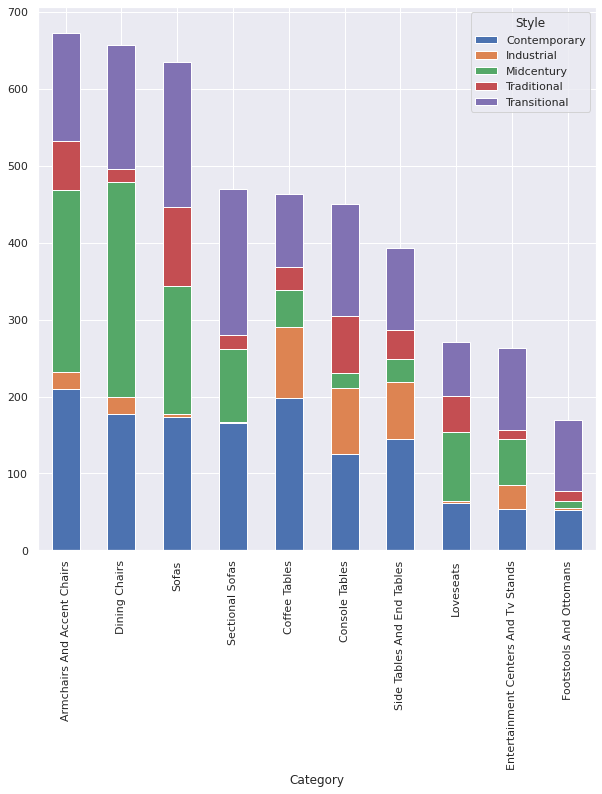

In [ ]:
eazyDf = tempDf[['Category','Price','Style']]
e = eazyDf.groupby(['Category','Style']).size().reset_index(name='Count')
e = pd.pivot(e, index='Category',columns='Style')

e.columns = e.columns.droplevel()


e['sum'] = e.sum(axis=1)
e = e.sort_values(by=['sum'],ascending=False )
e = e.drop(columns=['sum'])
e.plot(kind='bar',figsize=(10,10), stacked=True)


In [ ]:
tempDf.groupby("Category")['density'].describe().sort_values(by=['count'],ascending=False)

,count,mean,std,min,25%,50%,75%,max
Category,,,,,,,,
Armchairs And Accent Chairs,673.0,0.016369,0.120895,0.000077,0.001139,0.001417,0.001796,1.000000
Dining Chairs,657.0,0.003032,0.038990,0.000049,0.000952,0.001215,0.001863,1.000000
Sofas,635.0,0.001349,0.001416,0.000047,0.001052,0.001232,0.001429,0.033793
Sectional Sofas,470.0,0.001452,0.002914,0.000056,0.000727,0.000887,0.001208,0.044430
Coffee Tables,463.0,0.003820,0.006427,0.000047,0.002080,0.003121,0.004212,0.087302
Console Tables,450.0,0.002792,0.002295,0.000081,0.001701,0.002312,0.003179,0.031458
Side Tables And End Tables,393.0,0.003724,0.004872,0.000253,0.001973,0.002917,0.004277,0.087719
Loveseats,271.0,0.311347,5.102553,0.000056,0.001045,0.001214,0.001444,84.000000
Entertainment Centers And Tv Stands,263.0,0.008397,0.061476,0.000315,0.003255,0.003646,0.004622,1.000000


/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


(0.0, 10000.0)

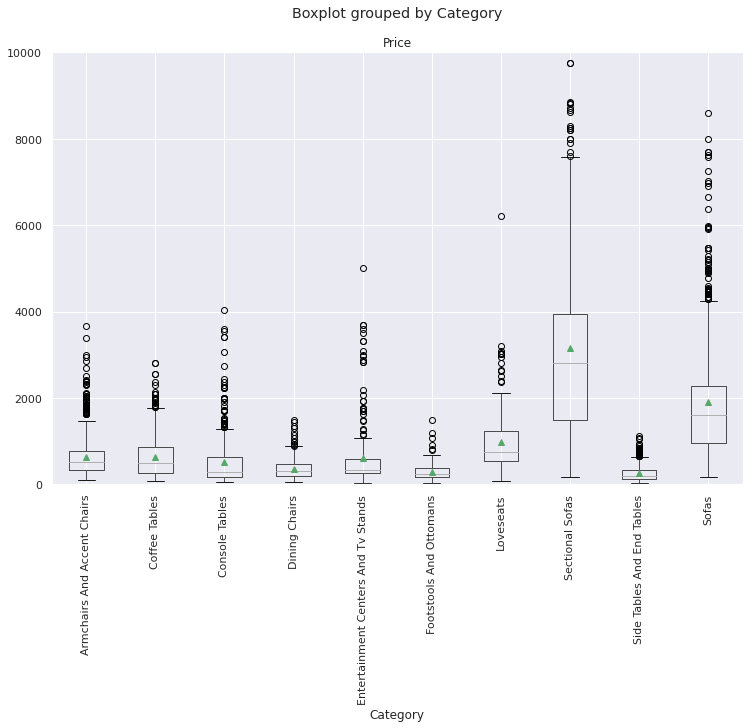

In [113]:
#kdf = tempDf[tempDf['Category'] == 'Coffee Tables']

kdf = tempDf

b = kdf.boxplot('Price', by='Category', figsize=(12, 8), rot=90,showmeans=True)
plt.ylim(0,10000)
#plt.title('Filtered to Sofas')

Text(0.5, 1.0, 'Price Histogram of Sofas')

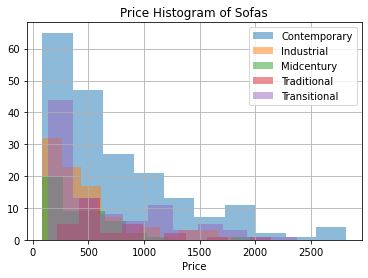

In [39]:
kdf.groupby(by='Style')['Price'].hist(alpha=0.5,legend=True)
plt.xlabel('Price')
plt.title('Price Histogram of Sofas')
#kdf.hist(column='Price',by='Style',bins=10)


##Histogram

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f6fbe9a03d0>,
      dtype=object)

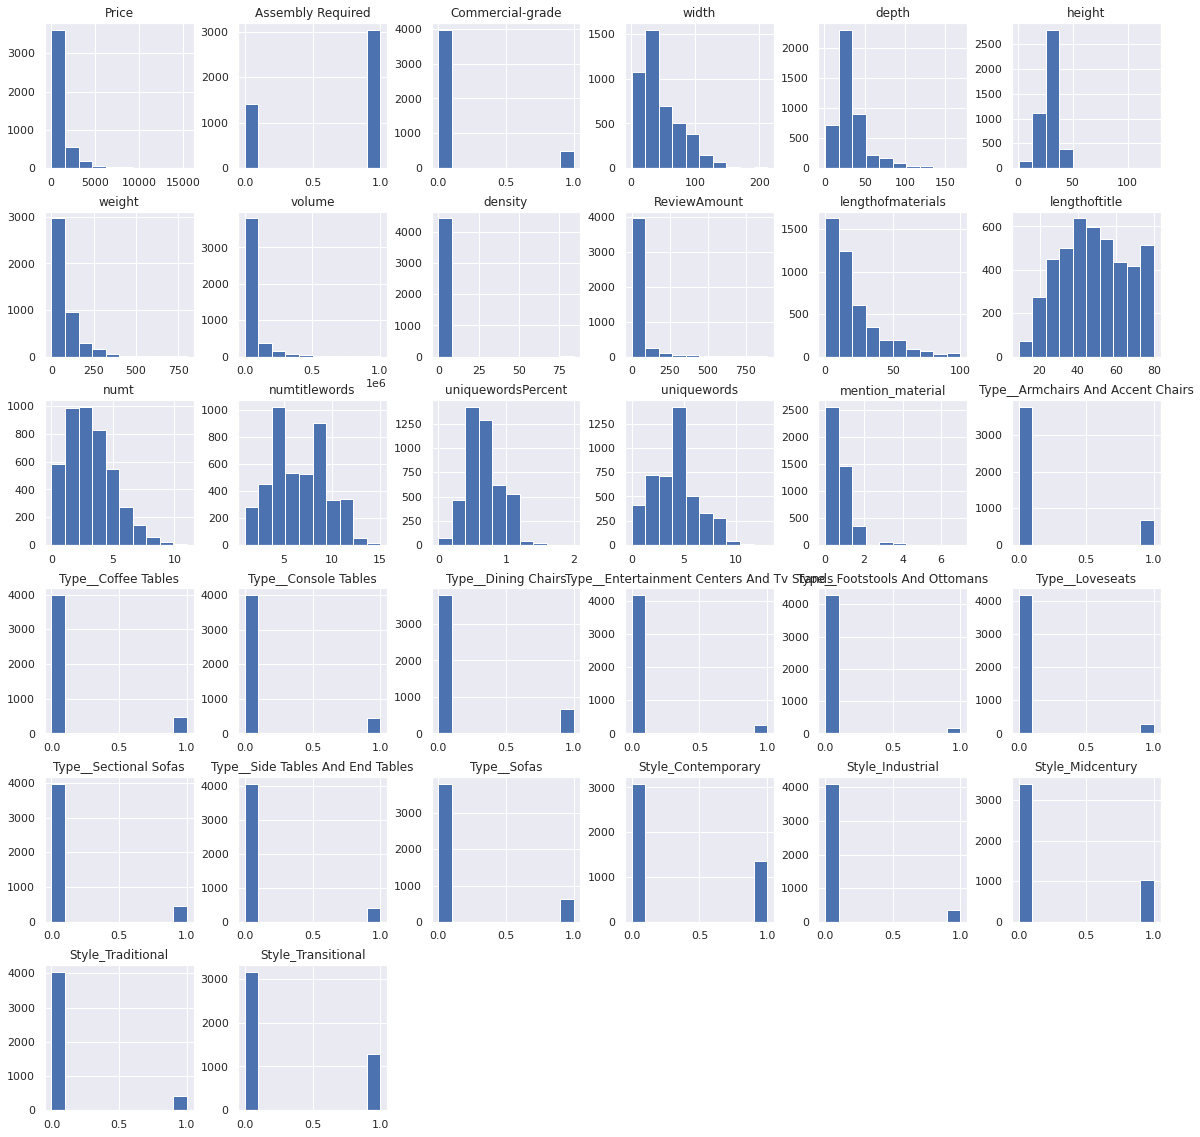

In [ ]:
tempDf.hist(figsize=(20,20))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f6fc923d410>,
      dtype=object)

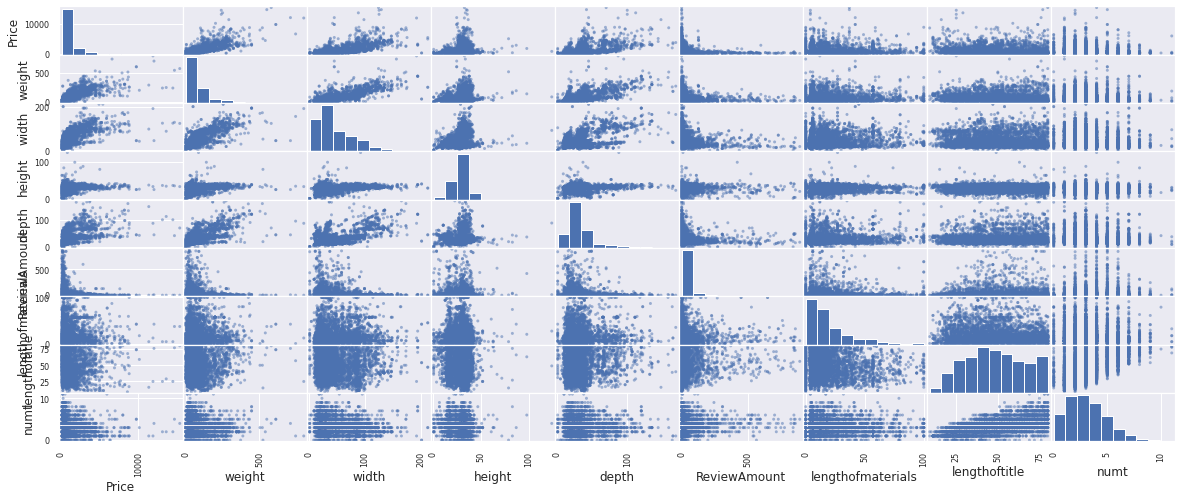

In [ ]:
snsDf = tempDf[['Price','weight','width','height','depth','ReviewAmount','lengthofmaterials','lengthoftitle','numt']]
pd.plotting.scatter_matrix(snsDf)

##Anova Table

In [ ]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

model = ols('Price ~ C(Category) + C(Style) + C(Category):C(Style)',data=tempDf).fit()
aov_table = sm.stats.anova_lm(model, typ=2)
aov_table

,sum_sq,df,F,PR(>F)
C(Category),3.435566e+09,9.0,391.060846,0.000000e+00
C(Style),6.021612e+07,4.0,15.422021,1.566486e-12
C(Category):C(Style),7.924932e+07,36.0,2.255182,2.773346e-05
Residual,4.289153e+09,4394.0,NaN,NaN


##VIF for multicolinearity

In [119]:
from IPython.core.display import Video

from statsmodels.stats.outliers_influence import variance_inflation_factor

X_variables = tempNum.drop(columns=['Price'])

vif_data = pd.DataFrame()
vif_data["feature"] = X_variables.columns
vif_data['VIF'] = [variance_inflation_factor(X_variables.values, i) for i in range(len(X_variables.columns))]

#vif_data = vif_data[vif_data['VIF'] != math.inf]
vif_data.sort_values(by='VIF',ascending=False)

/usr/local/lib/python3.7/dist-packages/statsmodels/stats/outliers_influence.py:185: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


,feature,VIF
30,Style_Transitional,inf
25,Type__Sofas,inf
23,Type__Sectional Sofas,inf
22,Type__Loveseats,inf
21,Type__Footstools And Ottomans,inf
20,Type__Entertainment Centers And Tv Stands,inf
19,Type__Dining Chairs,inf
18,Type__Console Tables,inf
17,Type__Coffee Tables,inf
16,Type__Armchairs And Accent Chairs,inf


#Model Building

##Random Forest

In [107]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn import model_selection, preprocessing, feature_selection, ensemble, linear_model, metrics, decomposition, tree


numDf = tempDf[tempDf.describe().columns]


#numDf = tempDf[['lengthoftitle','Assembly Required','ReviewAmount','numt','density','Price','Type__Sofas']]

#numDf = numDf.drop(columns=['weight','width','volume','density','depth','height'])

numDf = tempDf[['Price','weight','volume','Assembly Required','ReviewAmount']]

numDf =(numDf-numDf.mean())/numDf.std()

numDf['Category'] = tempDf['Category']

dtf_train, dtf_test = model_selection.train_test_split(numDf, test_size=0.3, random_state=15)

X_train = dtf_train.drop(columns=["Price",'Category'], axis=1).values
y_train = dtf_train["Price"].values

X_test = dtf_test.drop(columns=["Price",'Category'], axis=1).values
y_test = dtf_test["Price"].values

model = RandomForestRegressor(min_samples_split =4)
model.fit(X_train, y_train)

predictions = model.predict(X_test)

print(model.score(X_test,y_test))

feature_names = dtf_train.drop(columns=["Price",'Category'], axis=1).columns

importances = model.feature_importances_

##Extra Cross Validation

X = numDf.drop(columns=["Price",'Category'], axis=1).values
y = numDf["Price"].values

scores = model_selection.cross_val_score(model,X,y)
scores

print('Mean R2: %.5f (%.3f)' % (np.mean(scores), np.std(scores)))

0.7479240410622003
Mean R2: 0.74226 (0.015)


###Test from each cateogry

In [ ]:
for cat in np.sort(tempDf['Category'].unique()):
  #print('cat: ', cat)
  newTest = dtf_test[dtf_test['Category'] == cat]
  X_test = newTest.drop(columns=["Price",'Category'], axis=1).values
  y_test = newTest["Price"].values
  predictions = model.predict(X_test)
  #print('MSE :', metrics.mean_squared_error(y_test,predictions))
  #print('MAE :', metrics.mean_absolute_percentage_error(y_test,predictions))
  #print("RMSE : ", metrics.mean_squared_error(y_test,predictions))
  print(model.score(X_test,y_test))

0.3369165488706969
0.21181279285371157
0.49204336228664236
0.16388771881108533
0.8483752956111448
-0.16734053538607752
0.021605972957003394
0.29709827744102346
0.1489265326426219
0.5351444716371143


##Lasso Regression

In [99]:
from sklearn.linear_model import LassoCV
from sklearn.datasets import make_regression
from sklearn import metrics


model = LassoCV(cv=5, random_state=42).fit(X_train, y_train)

predictions = model.predict(X_test)

print('Regular R2 alpha: ', model.alpha_)
print(model.score(X_test,y_test))
print('MSE : ' ,metrics.mean_squared_error(y_test,predictions))
print('MAE : ' ,metrics.mean_absolute_percentage_error(y_test,predictions))




lasso =linear_model.Lasso(alpha=0.001472480754465545)
lasso.fit(X_train,y_train)

importances = np.abs(lasso.coef_)

print('lasso score: ',lasso.score(X_test,y_test))

Regular R2 alpha:  0.0007529494878879277
0.6295564419960942
MSE :  0.44177980343875783
MAE :  1.4189923429867801
lasso score:  0.6294358259860766


In [ ]:

def r2_score_adj(estimator, X, y):

    y_pred = estimator.predict(X)

    n = len(y)
    k = np.count_nonzero(estimator.coef_ > 0)

 

    r2 = metrics.r2_score(y, y_pred)

    r2_adjusted = 1 - ( ( (1 - r2)*(n - 1) )/ (n - k - 1) )

    return r2_adjusted 

model =linear_model.Lasso()

gcv = model_selection.GridSearchCV(estimator=model,  param_grid={'alpha': np.arange(0.009,0.02,0.00001)},scoring=r2_score_adj)
gcv.fit(X_test,y_test)


print('Adjustd R2: ', gcv.best_params_,' ',gcv.best_score_)
print(gcv.best_params_)

Adjustd R2:  {'alpha': 0.017279999999999664}   0.08335753276571234
{'alpha': 0.017279999999999664}


##Print Feature Importance

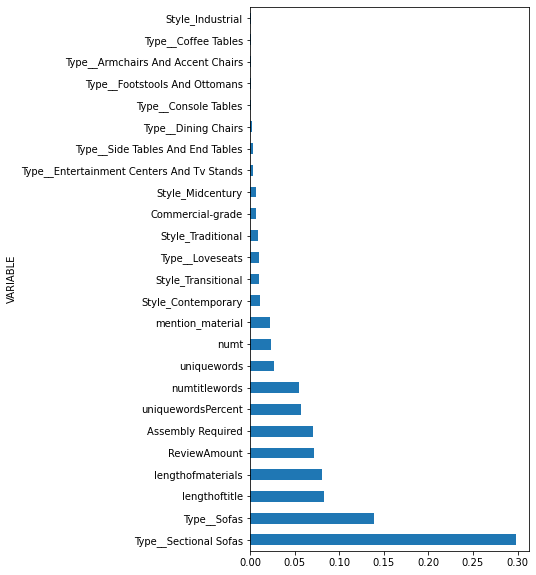

In [ ]:

dtf_importances = pd.DataFrame({"IMPORTANCE":importances, "VARIABLE":feature_names}).sort_values("IMPORTANCE", ascending=False)
dtf_importances = dtf_importances.set_index("VARIABLE")

dtf_importances['IMPORTANCE'].plot(kind='barh',figsize=(5,10))

##Train model for each cateogry

In [93]:
from sklearn.linear_model import LinearRegression



#numDf['Category'] = tempDf['Category']

for cat, df_cat in numDf.groupby('Category'):

  X = df_cat.drop(["Price",'Category'], axis=1).values
  
  y = df_cat["Price"].values

  model = LinearRegression()

  scores = model_selection.cross_val_score(model, X, y, scoring='r2', cv=5)
  #scores = absolute(scores)
  print('Mean R2: %.3f (%.3f) (%s)' % (np.mean(scores), np.std(scores), cat))



numDf = tempDf[tempDf.describe().columns]
numDf['Category'] = tempDf['Category']

feature_names = numDf.drop(["Price",'Category'], axis=1).columns


Mean R2: 0.397 (0.061) (Armchairs And Accent Chairs)
Mean R2: 0.535 (0.057) (Coffee Tables)
Mean R2: 0.597 (0.109) (Console Tables)
Mean R2: 0.050 (0.143) (Dining Chairs)
Mean R2: 0.619 (0.209) (Entertainment Centers And Tv Stands)
Mean R2: 0.394 (0.301) (Footstools And Ottomans)
Mean R2: 0.291 (0.205) (Loveseats)
Mean R2: 0.365 (0.118) (Sectional Sofas)
Mean R2: 0.402 (0.093) (Side Tables And End Tables)
Mean R2: 0.407 (0.110) (Sofas)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


#Residual Analysis

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


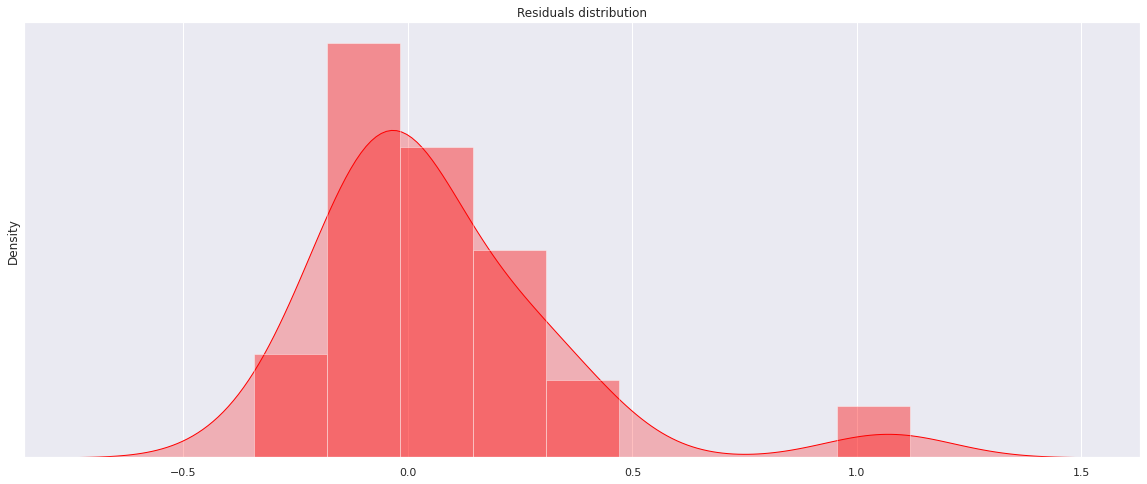

In [92]:
residuals = y_test - predictions

resDf = pd.DataFrame()
resDf['residuals'] = residuals
resDf["StdResidual"] = (resDf["residuals"] - resDf['residuals'].mean())/resDf['residuals'].std()

fig, ax = plt.subplots()
sns.distplot(residuals, color="red", hist=True, kde=True, kde_kws={"shade":True}, ax=ax)
ax.grid(True)
ax.set(yticks=[], yticklabels=[], title="Residuals distribution")
plt.show()

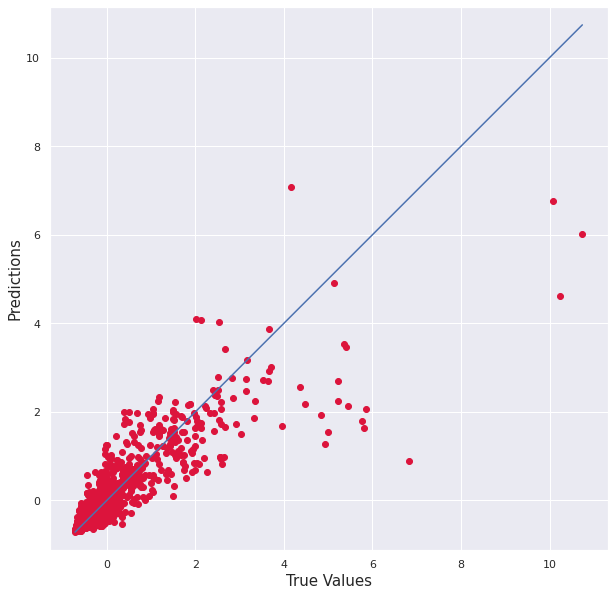

In [83]:
plt.figure(figsize=(10,10))
plt.scatter(y_test, predictions, c='crimson')
#plt.yscale('log')
#plt.xscale('log')

p1 = max(max(predictions), max(y_test))
p2 = min(min(predictions), min(y_test))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()

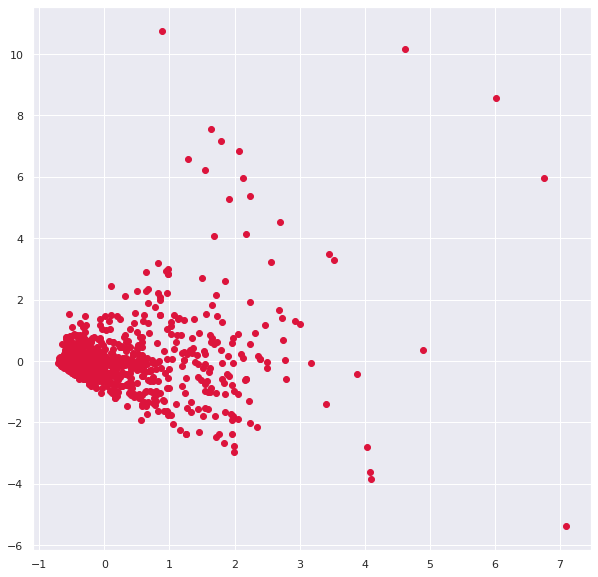

In [84]:
plt.figure(figsize=(10,10))
plt.scatter(predictions, resDf["StdResidual"],  c='crimson')

<class 'numpy.ndarray'>


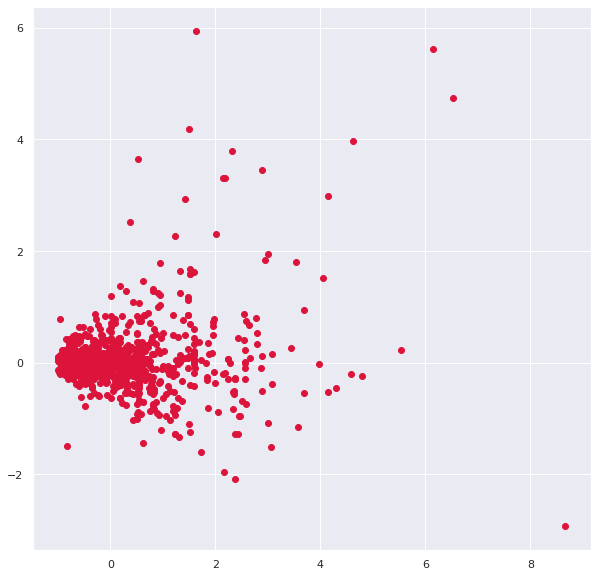

In [85]:
print(type(X_test))

plt.figure(figsize=(10,10))
plt.scatter(X_test[:,0], residuals, c='crimson')

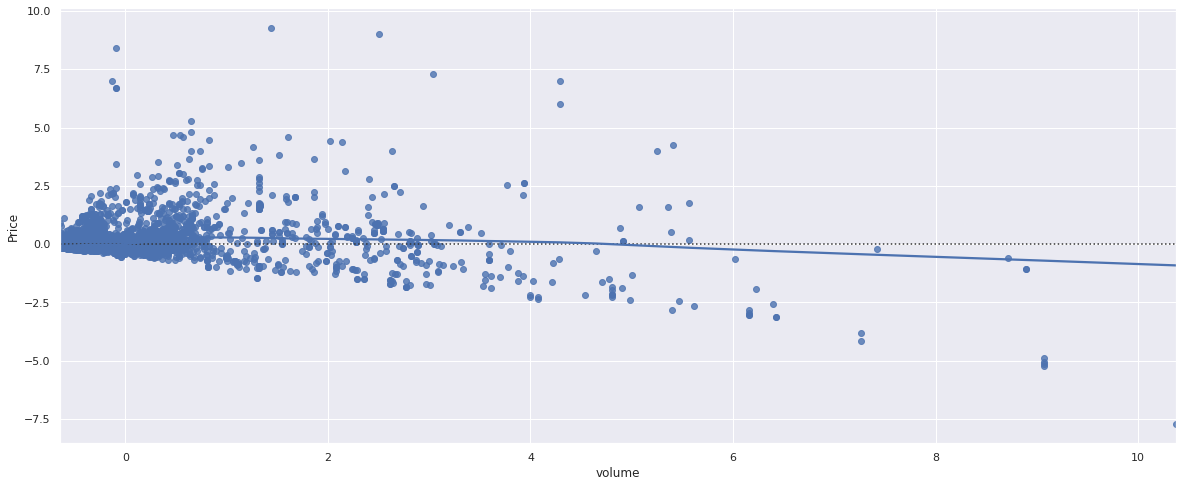

In [87]:
sns.residplot(x='volume', y='Price', data=numDf,lowess=True,robust=True)
#sns.regplot(x='weight', y='Price', data=tempDf)
plt.show()

Text(0, 0.5, 'Price')

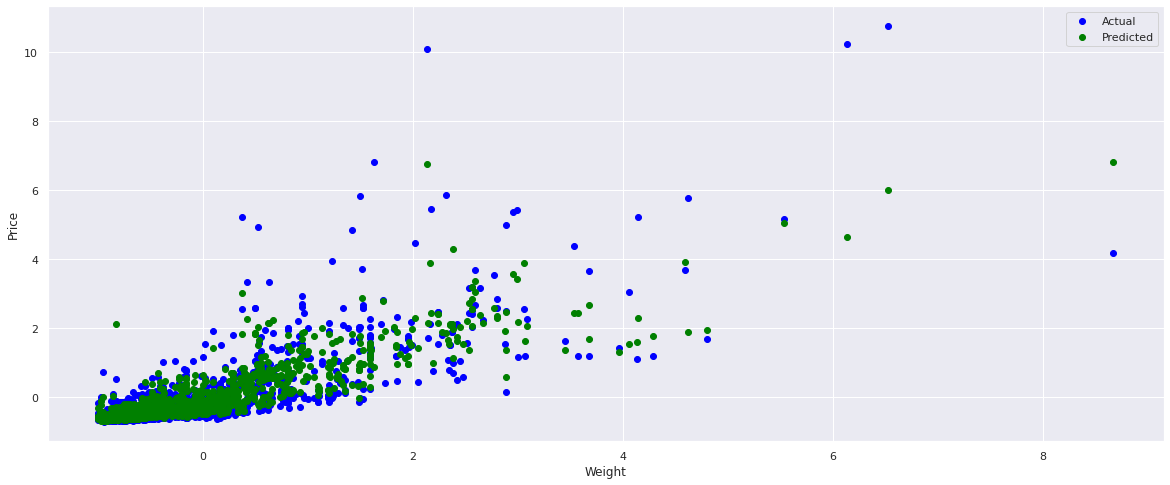

In [108]:
a = plt.scatter(X_test[:,0], y_test, color = 'blue')
b = plt.scatter(X_test[:,0], model.predict(X_test), color = 'green')
plt.legend((a,b),('Actual','Predicted'))
plt.xlabel('Weight')
plt.ylabel('Price')
